## Part 2: Supervised Baseline (Feedforward Network)
**Project**: FraudGuard - Credit Card Fraud Detection 

**Goal**: Train VAE and Apply Conformal predicitons.

In [4]:
import os
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve
)

c:\Programming\venvs\deep_learning_study\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [46]:
# ----------------------------
# Config
# ----------------------------
CSV_PATH = "creditcard.csv"   # <-- put your path here
RANDOM_STATE = 42

# Global split: main/calib/test
MAIN_FRAC  = 0.70
CALIB_FRAC = 0.10
TEST_FRAC  = 0.20

# VAE training split inside main-legit
VAE_VAL_FRAC = 0.20

# VAE hyperparams
BATCH_SIZE = 128
SCORE_BATCH_SIZE = 256
LR = 3e-4
WEIGHT_DECAY = 1e-5

EPOCHS = 40
PATIENCE = 10

PARAM_GRID = [
    {"latent_dim": 4,  "beta": 0.5},
    {"latent_dim": 8,  "beta": 0.5},
    {"latent_dim": 8,  "beta": 1},
    {"latent_dim": 16,  "beta": 0.5},
    {"latent_dim": 16, "beta": 1.0},
]

OUT_DIR = "outputs_vae_conformal"
os.makedirs(OUT_DIR, exist_ok=True)

# Reproducibility
def seed_everything(seed=RANDOM_STATE):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda


In [47]:
# ----------------------------
# 1) Load + Split data
# ----------------------------
df = pd.read_csv(CSV_PATH)

y = df["Class"].astype(int).values
X = df.drop(columns=["Class"]).values.astype(np.float32)

n = len(df)
print(f"Loaded: n={n}, fraud_rate={y.mean():.5f}")

# Global split: D_main, D_calib, D_test (stratified)
test_size_temp = 1.0 - MAIN_FRAC
X_main, X_temp, y_main, y_temp = train_test_split(
    X, y, test_size=test_size_temp, stratify=y, random_state=RANDOM_STATE
)

# Split temp into calib and test
# temp fraction = CALIB_FRAC + TEST_FRAC
calib_in_temp = CALIB_FRAC / (CALIB_FRAC + TEST_FRAC)
X_calib, X_test, y_calib, y_test = train_test_split(
    X_temp, y_temp, test_size=(1.0 - calib_in_temp),
    stratify=y_temp, random_state=RANDOM_STATE
)

print("\nGlobal splits:")
print(f"  D_main : {len(X_main)} (fraud_rate={y_main.mean():.5f})")
print(f"  D_calib: {len(X_calib)} (fraud_rate={y_calib.mean():.5f})")
print(f"  D_test : {len(X_test)} (fraud_rate={y_test.mean():.5f})")

# For VAE: use only legitimate transactions from D_main
X_main_legit = X_main[y_main == 0]
print(f"\nD_main_legit: {len(X_main_legit)}")

X_train_vae, X_val_vae = train_test_split(
    X_main_legit, test_size=VAE_VAL_FRAC, random_state=RANDOM_STATE
)

# Calibration for conformal: ONLY legitimate from D_calib (by ground-truth label)
X_calib_legit = X_calib[y_calib == 0]
print(f"D_calib_legit (for CP): {len(X_calib_legit)}")

# Standardize using ONLY VAE train-legit to avoid any test leakage
scaler = StandardScaler()
scaler.fit(X_train_vae)

X_train_vae_s = scaler.transform(X_train_vae).astype(np.float32)
X_val_vae_s   = scaler.transform(X_val_vae).astype(np.float32)

X_calib_legit_s = scaler.transform(X_calib_legit).astype(np.float32)
X_test_s        = scaler.transform(X_test).astype(np.float32)


Loaded: n=284807, fraud_rate=0.00173

Global splits:
  D_main : 199364 (fraud_rate=0.00173)
  D_calib: 28480 (fraud_rate=0.00172)
  D_test : 56963 (fraud_rate=0.00174)

D_main_legit: 199020
D_calib_legit (for CP): 28431


In [48]:
# ----------------------------
# Torch Dataset / Loader
# ----------------------------
def data_loader(X, batch_size=BATCH_SIZE):
    torch_loader = DataLoader(
        torch.tensor(X, dtype=torch.float32), 
        batch_size=batch_size, 
        shuffle=True,
        num_workers=0, 
        pin_memory=(device.type == "cuda")
    )
    return torch_loader

train_loader = data_loader(X_train_vae_s, BATCH_SIZE)
val_loader = data_loader(X_val_vae_s, BATCH_SIZE)

In [49]:
# ----------------------------
# 2) VAE definition + training utilities
# ----------------------------
class VAE(nn.Module):
    def __init__(self, input_dim: int, latent_dim: int):
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # encoder
        self.enc_fc1 = nn.Linear(input_dim, 64)
        self.enc_bn1 = nn.BatchNorm1d(64)
        self.enc_fc2 = nn.Linear(64, 32)
        self.enc_bn2 = nn.BatchNorm1d(32)
        self.fc_mu = nn.Linear(32, latent_dim)
        self.fc_logvar = nn.Linear(32, latent_dim)

        # decoder
        self.dec_fc1 = nn.Linear(latent_dim, 32)
        self.dec_fc2 = nn.Linear(32, 64)
        self.dec_fc3 = nn.Linear(64, input_dim)

    def encode(self, x):
        h = F.relu(self.enc_bn1(self.enc_fc1(x)))
        h = F.relu(self.enc_bn2(self.enc_fc2(h)))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.dec_fc1(z))
        h = F.relu(self.dec_fc2(h))
        return self.dec_fc3(h)  # linear for standardized continuous features

    def forward(self, x, deterministic: bool = False):
        mu, logvar = self.encode(x)
        z = mu if deterministic else self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

def vae_loss(recon, x, mu, logvar, beta=1.0):
    recon_loss = ((recon - x) ** 2).mean(dim=1).mean()  # per-sample mse -> mean
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    total = recon_loss + beta * kl
    return total, recon_loss, kl

def eval_epoch(model, loader, beta=1.0):
    with torch.no_grad():
        model.eval()
        tot, rec, klv, n = 0.0, 0.0, 0.0, 0
        for x in loader:
            x = x.to(device)
            recon, mu, logvar = model(x, deterministic=True)
            loss, rloss, kl = vae_loss(recon, x, mu, logvar, beta)
            bs = x.size(0)
            tot += loss.item() * bs
            rec += rloss.item() * bs
            klv += kl.item() * bs
            n += bs
    return tot / n, rec / n, klv / n

In [52]:
def train_vae(model, train_loader, val_loader, beta, epochs, lr, weight_decay, patience):
    optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    history = {
        "train_total": [], "train_recon": [], "train_kl": [],
        "val_total": [], "val_recon": [], "val_kl": []
    }

    best_val_recon = float("inf")
    best_val_total = float("inf")
    best_state = None
    best_epoch = -1
    bad_epochs = 0

    warmup_epochs = 10  # KL warmup

    for epoch in tqdm(range(1, epochs + 1), desc="epochs", leave=True):
        model.train()
        tot, rec, klv, n = 0.0, 0.0, 0.0, 0

        beta_t = beta * min(1.0, epoch / warmup_epochs)

        for x in train_loader:
            x = x.to(device)
            optim.zero_grad(set_to_none=True)

            recon, mu, logvar = model(x)
            loss, rloss, kl = vae_loss(recon, x, mu, logvar, beta_t)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)  # clipping grad
            optim.step()

            bs = x.size(0)
            tot += loss.item() * bs
            rec += rloss.item() * bs
            klv += kl.item() * bs
            n += bs

        train_total = tot / n
        train_recon = rec / n
        train_kl = klv / n

        val_total, val_recon, val_kl = eval_epoch(model, val_loader, beta)

        history["train_total"].append(train_total)
        history["train_recon"].append(train_recon)
        history["train_kl"].append(train_kl)
        history["val_total"].append(val_total)
        history["val_recon"].append(val_recon)
        history["val_kl"].append(val_kl)
        
        if epoch == 1 or epoch % 3 == 0 or epoch == epochs:
            print(
                f"epoch {epoch:03d} | "
                f"train total={train_total:.3f} recon={train_recon:.3f} kl={train_kl:.3f} | "
                f"val total={val_total:.3f} recon={val_recon:.3f} kl={val_kl:.3f}"
            )

        # Early stopping criterion for grid search:
        # prioritize val_recon (since anomaly score uses recon MSE), tie-break with val_total
        improved = (val_recon < best_val_recon - 1e-7) or (
            abs(val_recon - best_val_recon) <= 1e-7 and val_total < best_val_total - 1e-7
        )
        if improved:
            best_val_recon = val_recon
            best_val_total = val_total
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            best_epoch = epoch
            bad_epochs = 0
        else:
            bad_epochs += 1
            if bad_epochs >= patience:
                print(f"Early stopping at epoch {epoch}. Best epoch: {best_epoch} (val_recon={best_val_recon:.3f})")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    return history, best_epoch, best_val_recon, best_val_total

In [53]:
# ----------------------------
# 2b) Grid search (<= 5 runs)
# ----------------------------
input_dim = X_train_vae.shape[1]
best = None  # will store dict with model + params + stats

for i, cfg in enumerate(PARAM_GRID, start=1):
    seed_everything(RANDOM_STATE + i)  # stable but different init per config
    latent_dim = cfg["latent_dim"]
    beta = cfg["beta"]

    print(f"\n--- Config {i}/{len(PARAM_GRID)}: latent_dim={latent_dim}, beta={beta} ---")
    model = VAE(input_dim=input_dim, latent_dim=latent_dim).to(device)

    hist, be, val_recon_best, val_total_best = train_vae(
        model, train_loader, val_loader,
        beta=beta, epochs=EPOCHS, lr=LR, weight_decay=WEIGHT_DECAY, patience=PATIENCE
    )

    summary = {
        "cfg": cfg,
        "model_state": {k: v.detach().cpu().clone() for k, v in model.state_dict().items()},
        "history": hist,
        "best_epoch": be,
        "best_val_recon": val_recon_best,
        "best_val_total": val_total_best,
    }

    if best is None:
        best = summary
    else:
        # choose best by val_recon, tie-break with val_total
        improved = (summary["best_val_recon"] < best["best_val_recon"] - 1e-7) or (
            abs(summary["best_val_recon"] - best["best_val_recon"]) <= 1e-7 and
            summary["best_val_total"] < best["best_val_total"] - 1e-7
        )
        if improved:
            best = summary

print("\n====================")
print("Best config selected\n")
print(f"  latent_dim={best['cfg']['latent_dim']}, beta={best['cfg']['beta']}")
print(f"  best_epoch={best['best_epoch']}")
print(f"  best_val_recon={best['best_val_recon']:.3f}")
print(f"  best_val_total={best['best_val_total']:.3f}")

# Restore best model
vae = VAE(input_dim=input_dim, latent_dim=best["cfg"]["latent_dim"]).to(device)
vae.load_state_dict(best["model_state"])
history = best["history"]
BETA = best["cfg"]["beta"]



--- Config 1/5: latent_dim=4, beta=0.5 ---


epochs:   2%|▎         | 1/40 [00:07<05:00,  7.72s/it]

epoch 001 | train total=0.885 recon=0.845 kl=0.804 | val total=1.419 recon=0.698 kl=1.442


epochs:   8%|▊         | 3/40 [00:24<05:06,  8.28s/it]

epoch 003 | train total=0.794 recon=0.666 kl=0.849 | val total=1.039 recon=0.599 kl=0.878


epochs:  15%|█▌        | 6/40 [00:50<04:49,  8.52s/it]

epoch 006 | train total=0.845 recon=0.690 kl=0.516 | val total=0.884 recon=0.615 kl=0.538


epochs:  22%|██▎       | 9/40 [01:17<04:34,  8.86s/it]

epoch 009 | train total=0.877 recon=0.751 kl=0.280 | val total=0.844 recon=0.705 kl=0.278


epochs:  30%|███       | 12/40 [01:44<04:13,  9.05s/it]

epoch 012 | train total=0.870 recon=0.778 kl=0.184 | val total=0.849 recon=0.754 kl=0.190


epochs:  32%|███▎      | 13/40 [02:02<04:14,  9.44s/it]


Early stopping at epoch 14. Best epoch: 4 (val_recon=0.596)

--- Config 2/5: latent_dim=8, beta=0.5 ---


epochs:   2%|▎         | 1/40 [00:08<05:48,  8.95s/it]

epoch 001 | train total=0.841 recon=0.803 kl=0.746 | val total=1.269 recon=0.611 kl=1.316


epochs:   8%|▊         | 3/40 [00:27<05:36,  9.09s/it]

epoch 003 | train total=0.680 recon=0.537 kl=0.955 | val total=0.935 recon=0.446 kl=0.978


epochs:  15%|█▌        | 6/40 [00:54<05:09,  9.11s/it]

epoch 006 | train total=0.717 recon=0.514 kl=0.679 | val total=0.752 recon=0.403 kl=0.699


epochs:  22%|██▎       | 9/40 [01:20<04:30,  8.72s/it]

epoch 009 | train total=0.769 recon=0.554 kl=0.478 | val total=0.676 recon=0.433 kl=0.487


epochs:  30%|███       | 12/40 [01:45<03:59,  8.55s/it]

epoch 012 | train total=0.774 recon=0.571 kl=0.406 | val total=0.664 recon=0.464 kl=0.400


epochs:  38%|███▊      | 15/40 [02:10<03:31,  8.44s/it]

epoch 015 | train total=0.763 recon=0.565 kl=0.397 | val total=0.660 recon=0.455 kl=0.409


epochs:  38%|███▊      | 15/40 [02:19<03:51,  9.28s/it]


Early stopping at epoch 16. Best epoch: 6 (val_recon=0.403)

--- Config 3/5: latent_dim=8, beta=1 ---


epochs:   2%|▎         | 1/40 [00:08<05:37,  8.66s/it]

epoch 001 | train total=0.879 recon=0.833 kl=0.467 | val total=1.491 recon=0.623 kl=0.868


epochs:   8%|▊         | 3/40 [00:25<05:09,  8.37s/it]

epoch 003 | train total=0.794 recon=0.640 kl=0.512 | val total=1.078 recon=0.540 kl=0.538


epochs:  15%|█▌        | 6/40 [00:50<04:43,  8.33s/it]

epoch 006 | train total=0.841 recon=0.676 kl=0.276 | val total=0.863 recon=0.584 kl=0.278


epochs:  22%|██▎       | 9/40 [01:16<04:26,  8.61s/it]

epoch 009 | train total=0.861 recon=0.740 kl=0.135 | val total=0.828 recon=0.686 kl=0.141


epochs:  30%|███       | 12/40 [01:43<04:08,  8.87s/it]

epoch 012 | train total=0.854 recon=0.762 kl=0.092 | val total=0.832 recon=0.733 kl=0.098


epochs:  32%|███▎      | 13/40 [02:01<04:12,  9.34s/it]


Early stopping at epoch 14. Best epoch: 4 (val_recon=0.535)

--- Config 4/5: latent_dim=16, beta=0.5 ---


epochs:   2%|▎         | 1/40 [00:09<05:59,  9.22s/it]

epoch 001 | train total=0.782 recon=0.746 kl=0.726 | val total=1.166 recon=0.508 kl=1.317


epochs:   8%|▊         | 3/40 [00:27<05:36,  9.09s/it]

epoch 003 | train total=0.545 recon=0.409 kl=0.905 | val total=0.771 recon=0.306 kl=0.931


epochs:  15%|█▌        | 6/40 [01:09<07:31, 13.27s/it]

epoch 006 | train total=0.566 recon=0.364 kl=0.672 | val total=0.580 recon=0.244 kl=0.673


epochs:  22%|██▎       | 9/40 [01:48<06:40, 12.93s/it]

epoch 009 | train total=0.612 recon=0.373 kl=0.532 | val total=0.494 recon=0.231 kl=0.525


epochs:  30%|███       | 12/40 [02:28<06:15, 13.41s/it]

epoch 012 | train total=0.616 recon=0.370 kl=0.493 | val total=0.468 recon=0.221 kl=0.494


epochs:  38%|███▊      | 15/40 [03:10<05:44, 13.78s/it]

epoch 015 | train total=0.602 recon=0.354 kl=0.496 | val total=0.458 recon=0.221 kl=0.474


epochs:  45%|████▌     | 18/40 [03:53<05:06, 13.94s/it]

epoch 018 | train total=0.592 recon=0.341 kl=0.502 | val total=0.454 recon=0.204 kl=0.499


epochs:  52%|█████▎    | 21/40 [04:30<04:07, 13.02s/it]

epoch 021 | train total=0.582 recon=0.330 kl=0.505 | val total=0.435 recon=0.184 kl=0.502


epochs:  60%|██████    | 24/40 [05:00<02:50, 10.67s/it]

epoch 024 | train total=0.577 recon=0.323 kl=0.508 | val total=0.434 recon=0.185 kl=0.499


epochs:  68%|██████▊   | 27/40 [05:25<02:00,  9.26s/it]

epoch 027 | train total=0.572 recon=0.317 kl=0.510 | val total=0.429 recon=0.177 kl=0.504


epochs:  75%|███████▌  | 30/40 [05:51<01:28,  8.85s/it]

epoch 030 | train total=0.567 recon=0.311 kl=0.512 | val total=0.428 recon=0.167 kl=0.521


epochs:  82%|████████▎ | 33/40 [06:18<01:02,  8.93s/it]

epoch 033 | train total=0.563 recon=0.306 kl=0.514 | val total=0.426 recon=0.169 kl=0.514


epochs:  90%|█████████ | 36/40 [06:45<00:35,  8.94s/it]

epoch 036 | train total=0.559 recon=0.302 kl=0.516 | val total=0.421 recon=0.165 kl=0.513


epochs:  98%|█████████▊| 39/40 [07:14<00:09,  9.48s/it]

epoch 039 | train total=0.556 recon=0.298 kl=0.517 | val total=0.420 recon=0.165 kl=0.509


epochs: 100%|██████████| 40/40 [07:23<00:00, 11.09s/it]


epoch 040 | train total=0.555 recon=0.297 kl=0.518 | val total=0.421 recon=0.163 kl=0.517

--- Config 5/5: latent_dim=16, beta=1.0 ---


epochs:   2%|▎         | 1/40 [00:09<05:52,  9.03s/it]

epoch 001 | train total=0.820 recon=0.772 kl=0.486 | val total=1.392 recon=0.558 kl=0.834


epochs:   8%|▊         | 3/40 [00:27<05:35,  9.06s/it]

epoch 003 | train total=0.672 recon=0.514 kl=0.527 | val total=0.960 recon=0.398 kl=0.562


epochs:  15%|█▌        | 6/40 [00:54<05:05,  8.99s/it]

epoch 006 | train total=0.718 recon=0.506 kl=0.354 | val total=0.708 recon=0.432 kl=0.276


epochs:  22%|██▎       | 9/40 [01:22<04:52,  9.44s/it]

epoch 009 | train total=0.772 recon=0.556 kl=0.241 | val total=0.660 recon=0.419 kl=0.241


epochs:  30%|███       | 12/40 [01:48<04:08,  8.89s/it]

epoch 012 | train total=0.777 recon=0.576 kl=0.202 | val total=0.660 recon=0.453 kl=0.207


epochs:  35%|███▌      | 14/40 [02:15<04:10,  9.65s/it]

epoch 015 | train total=0.767 recon=0.568 kl=0.199 | val total=0.653 recon=0.452 kl=0.200
Early stopping at epoch 15. Best epoch: 5 (val_recon=0.363)

Best config selected

  latent_dim=16, beta=0.5
  best_epoch=38
  best_val_recon=0.162
  best_val_total=0.419



Saved loss plots:
  outputs_vae_conformal\vae_loss_total_train_vs_val.png
  outputs_vae_conformal\vae_loss_recon_train_vs_val.png


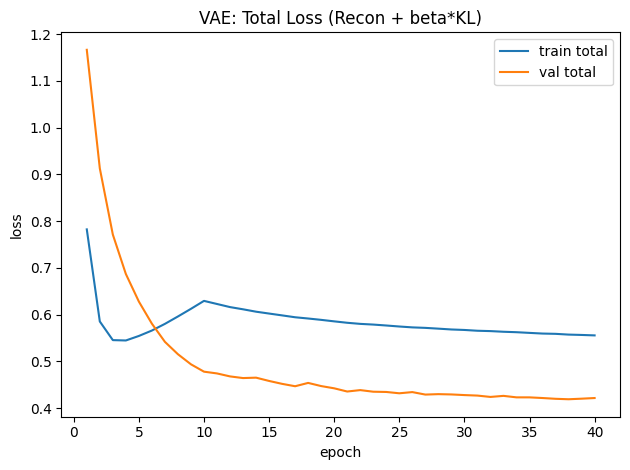

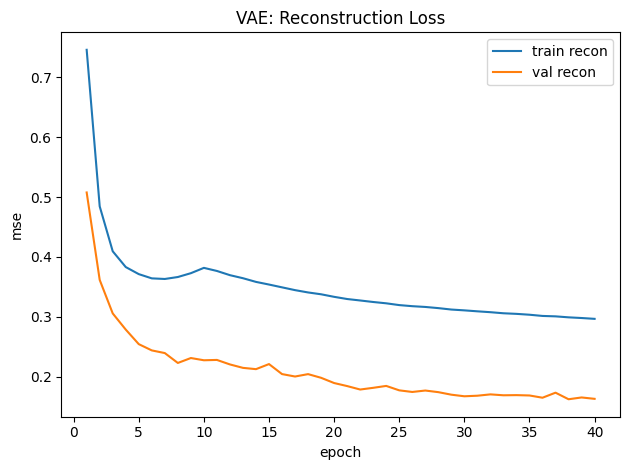

In [ ]:
# ----------------------------
# Save 2 loss images for best run
# ----------------------------
epochs_r = np.arange(1, len(history["train_total"]) + 1)

plt.figure()
plt.plot(epochs_r, history["train_total"], label="train total")
plt.plot(epochs_r, history["val_total"], label="val total")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("VAE: Total Loss (Recon + beta*KL)")
plt.legend()
plt.tight_layout()
loss_total_path = os.path.join(OUT_DIR, "vae_loss_total_train_vs_val.png")
#plt.savefig(loss_total_path, dpi=200)
#plt.close()

plt.figure()
plt.plot(epochs_r, history["train_recon"], label="train recon")
plt.plot(epochs_r, history["val_recon"], label="val recon")
plt.xlabel("epoch")
plt.ylabel("mse")
plt.title("VAE: Reconstruction Loss")
plt.legend()
plt.tight_layout()
loss_recon_path = os.path.join(OUT_DIR, "vae_loss_recon_train_vs_val.png")
#plt.savefig(loss_recon_path, dpi=200)
#plt.close()

print("\nSaved loss plots:")
print(f"  {loss_total_path}")
print(f"  {loss_recon_path}")


VAE score metrics on TEST (score = recon MSE):
  ROC-AUC = 0.481251
  PR-AUC  = 0.001677

Saved ROC/PR plots:
  outputs_vae_conformal\vae_roc_curve.png
  outputs_vae_conformal\vae_pr_curve.png


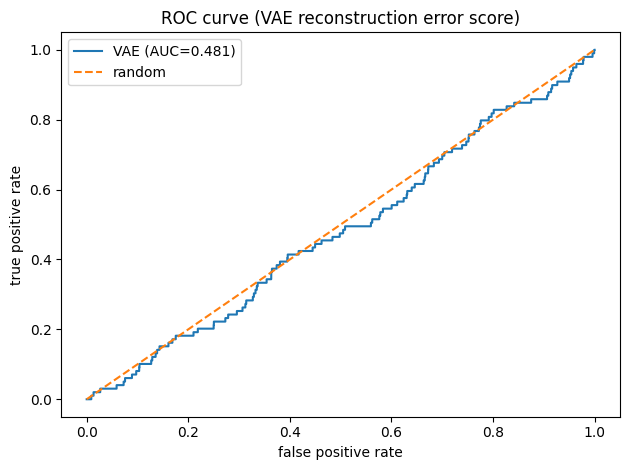

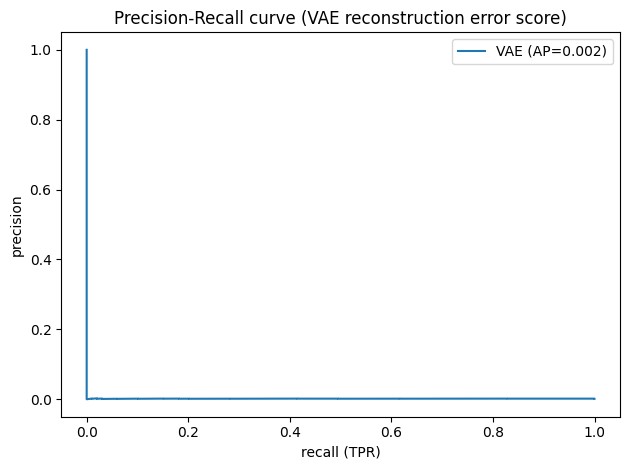

In [76]:
# ----------------------------
# Helper: compute VAE reconstruction error scores
# ----------------------------
def vae_scores_mse(model, X_np, batch_size=SCORE_BATCH_SIZE):
    with torch.no_grad():
        """Return per-sample reconstruction MSE scores."""
        model.eval()
        X_loaded = data_loader(X_np, batch_size=batch_size)
        scores = []
        for x in X_loaded:
            x = x.to(device)
            recon, _, _ = model(x)
            s = ((x - recon) ** 2).mean(dim=1)  # per-sample MSE
            scores.append(s.detach().cpu().numpy())
    return np.concatenate(scores, axis=0)

# ----------------------------
# 3) ROC-AUC + PR-AUC curves for VAE scores on TEST
# ----------------------------
scores_test = vae_scores_mse(vae, X_test_s)
roc_auc = roc_auc_score(y_test, scores_test)
pr_auc  = average_precision_score(y_test, scores_test)

print(f"\nVAE score metrics on TEST (score = recon MSE):")
print(f"  ROC-AUC = {roc_auc:.6f}")
print(f"  PR-AUC  = {pr_auc:.6f}")

# ROC curve
fpr, tpr, _ = roc_curve(y_test, scores_test)
plt.figure()
plt.plot(fpr, tpr, label=f"VAE (AUC={roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="random")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("ROC curve (VAE reconstruction error score)")
plt.legend()
plt.tight_layout()
roc_path = os.path.join(OUT_DIR, "vae_roc_curve.png")
#plt.savefig(roc_path, dpi=200)
#plt.close()

# PR curve
precision, recall, _ = precision_recall_curve(y_test, scores_test)
plt.figure()
plt.plot(recall, precision, label=f"VAE (AP={pr_auc:.3f})")
plt.xlabel("recall (TPR)")
plt.ylabel("precision")
plt.title("Precision-Recall curve (VAE reconstruction error score)")
plt.legend()
plt.tight_layout()
pr_path = os.path.join(OUT_DIR, "vae_pr_curve.png")
#plt.savefig(pr_path, dpi=200)
#plt.close()

print("\nSaved ROC/PR plots:")
print(f"  {roc_path}")
print(f"  {pr_path}")